In [18]:
%load_ext autoreload
%autoreload 2
# Checking the json file with the original data to adapt it to my storage
# location for the same data, and updating the file in a new file named:
# 'train_corpus_local.json'
from data_generator import vis_train_features, plot_raw_audio
from data_generator import plot_spectrogram_feature
from data_generator import plot_mfcc_feature
from IPython.display import Markdown, display
from mpl_toolkits.axes_grid1 import make_axes_locatable

from keras.backend import set_session
import tensorflow as tf

# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

import matplotlib.pyplot as plt
import json
import os
import numpy as np
import soundfile as sf
import miniaudio
import array


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def json_to_local(desc_file='train_corpus.json',
                  new_file='train_corpus_local.json', folder='dev-clean'):
    new_base_path = '/Volumes/OutSSD/DATA/NLP/'
    keys, durations, labels = [], [], []
    with open(desc_file) as json_line_file:
        for json_line in json_line_file:
            spec = json.loads(json_line)
            keys.append(spec['key'].replace('/data/nlpnd_projects/',
                        new_base_path))
            durations.append(spec['duration'])
            labels.append(spec['text'])
        json_line_file.close()
    with open(new_file, 'w') as out_file:
        for i in range(len(keys)):
            line = json.dumps({'key': keys[i], 'duration': durations[i],
                              'text': labels[i]})
            out_file.write(line + '\n')
        out_file.close()

    print('New json file ready')

In [3]:
def play_back_file(filename):
    stream = miniaudio.stream_file(filename)
    device = miniaudio.PlaybackDevice()
    device.start(stream)
    input("Audio file playing in the background. Enter to stop playback: ")
    device.close()

In [4]:
def flac_to_wav_wminiaudio(filename, new_file):

    src = miniaudio.decode_file(filename, dither=miniaudio.DitherMode.TRIANGLE)
    # In case you want to print the source file info: decomment
    # print("Source: ", src)
    result = miniaudio.DecodedSoundFile("result", src.nchannels,
                                        src.sample_rate, src.sample_format,
                                        array.array('b'))
    converted_frames = miniaudio.convert_frames(src.sample_format,
                                                src.nchannels, src.sample_rate,
                                                src.samples.tobytes(),
                                                result.sample_format,
                                                result.nchannels,
                                                result.sample_rate)
    # note: currently it is not possible to provide a dithermode
    # to convert_frames()
    result.num_frames = int(len(converted_frames) /
                            result.nchannels /
                            result.sample_width)
    result.samples.frombytes(converted_frames)
    miniaudio.wav_write_file(new_file, result)
    # In case you want to print the output file info: decomment
    # output_info = miniaudio.get_file_info(new_file)
    # print(output_info)


In [5]:
def convert_flac_files(data_directory, lib='mini'):

    for group in os.listdir(data_directory):

        if not group.startswith('.'):
            group_folder = os.path.join(data_directory, group)
            for speaker in os.listdir(group_folder):
                if not speaker.startswith('.'):
                    speaker_folder = os.path.join(data_directory, group,
                                                  speaker)
                    for file in os.listdir(speaker_folder):
                        if (not file.startswith('.')) and \
                                file.endswith('.flac'):
                            filename = os.path.join(speaker_folder, file)
                            new_file = file[:-4]+'wav'
                            new_path = os.path.join(speaker_folder, new_file)
                            if lib == 'mini':
                                flac_to_wav_wminiaudio(filename, new_path)
                            elif lib == 'sf':
                                data, samplerate = sf.read(filename)
                                sf.write(new_path, data, samplerate, 'PCM_16')

    print('.flac files converted to .wav with {}'.format(lib))

In [6]:
wk_directory = '/Users/carlosarocha/Dropbox/AI/GITHUB/UDACITY/NLP/' +\
    'DNN_Speech_Recognizer'
os.chdir(wk_directory)
data_directory_test = '/Volumes/OutSSD/DATA/NLP/LibriSpeech/dev-clean'
data_directory_valid = '/Volumes/OutSSD/DATA/NLP/LibriSpeech/test-clean'

In [7]:
# FIRST STEP: Change original json file to a file with the local addresses of
# sound files
json_to_local()
json_to_local(desc_file='valid_corpus.json',
               new_file='valid_corpus_local.json')

New json file ready
New json file ready


In [9]:
# SECOND STEP: TO CONVERT THE DATA FROM FLAC TO WAV,we can use soundfile library
#  with lib='sf' or miniaudio library lib='mini'
convert_flac_files(data_directory_test, lib='sf')
convert_flac_files(data_directory_valid, lib='sf')

.flac files converted to .wav with sf
.flac files converted to .wav with sf


In [23]:
# extract label and audio features for a single training example
json_file = 'train_corpus_local.json'
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features(desc_file=json_file)

There are 2023 total training examples.


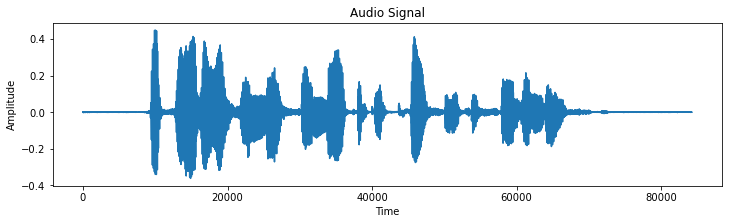

**Shape of Audio Signal** : (84231,)
**Transcript** : her father is a most remarkable person to say the least
Audio file playing in the background. Enter to stop playback: 


In [25]:
# plot audio signal
plot_raw_audio(vis_raw_audio)
plt.show(block=False)
# print length of audio signal
print('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape))
# print transcript corresponding to audio clip
print('**Transcript** : ' + str(vis_text))
# play the audio file
play_back_file(vis_audio_path)

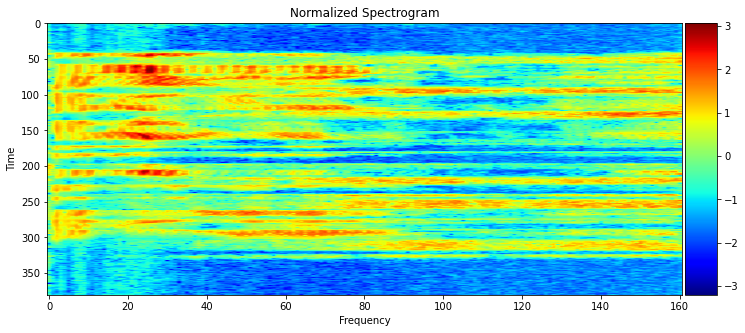

**Shape of Spectrogram** : (381, 161)


In [26]:
# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
print('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape))

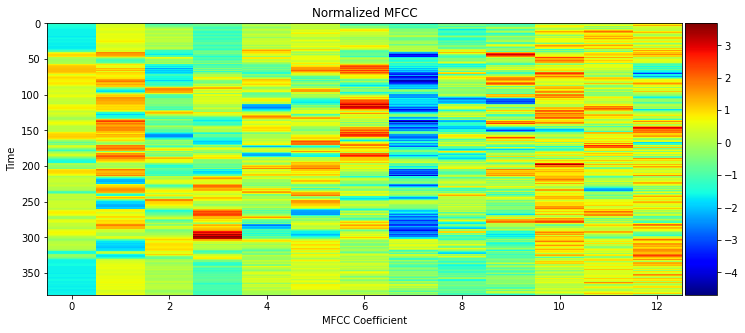

**Shape of MFCC** : (381, 13)


In [27]:
# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
print('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape))

In [50]:
%%time
# Main acoustic input
input_dim = 161
output_dim = 29
input_data = Input(name='the_input', shape=(None, input_dim))
# Add recurrent layer
simp_rnn = GRU(output_dim, return_sequences=True,
                   implementation=2, name='rnn')(input_data)
# Add softmax activation layer
y_pred = Activation('softmax', name='softmax')(simp_rnn)
# Specify the model
model_end = Model(inputs=input_data, outputs=y_pred)
model_end.output_length = lambda x: x
print(model_end.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None, 161)]       0         
                                                                 
 rnn (GRU)                   (None, None, 29)          16704     
                                                                 
 softmax (Activation)        (None, None, 29)          0         
                                                                 
Total params: 16,704
Trainable params: 16,704
Non-trainable params: 0
_________________________________________________________________
None
CPU times: user 63.7 ms, sys: 8.48 ms, total: 72.2 ms
Wall time: 70.5 ms


In [56]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [57]:
def add_ctc_loss(input_to_softmax):
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int64')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int64')
    output_lengths = Lambda(input_to_softmax.output_length)(input_lengths)
    # CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [input_to_softmax.output, the_labels, output_lengths, label_lengths])
    model = Model(
        inputs=[input_to_softmax.input, the_labels, input_lengths,
                label_lengths],
        outputs=loss_out)
    return model

In [55]:
from data_generator import AudioGenerator
import _pickle as pickle

from keras import backend as K
from keras.models import Model
from keras.layers import (Input, Lambda)
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

input_to_softmax=model_end
pickle_path='model_end.pickle'
save_model_path='model_end.h5'
train_json='train_corpus_local.json'
valid_json='valid_corpus_local.json'
minibatch_size=20
spectrogram=True
mfcc_dim=13
optimizer=SGD(learning_rate=0.02, decay=1e-6, momentum=0.9,
              nesterov=True,
              clipnorm=5)
epochs=2
verbose=1
sort_by_duration=False
max_duration=10.0

# create a class instance for obtaining batches of data
audio_gen = AudioGenerator(minibatch_size=minibatch_size,
                           spectrogram=spectrogram, mfcc_dim=mfcc_dim,
                           max_duration=max_duration,
                           sort_by_duration=sort_by_duration)

# add the training data to the generator
audio_gen.load_train_data(train_json)
audio_gen.load_validation_data(valid_json)
# calculate steps_per_epoch
num_train_examples = len(audio_gen.train_audio_paths)
steps_per_epoch = num_train_examples//minibatch_size
# calculate validation_steps
num_valid_samples = len(audio_gen.valid_audio_paths)
validation_steps = num_valid_samples//minibatch_size

# add CTC loss to the NN specified in input_to_softmax
model = add_ctc_loss(input_to_softmax)

# CTC loss is implemented elsewhere, so use a dummy lambda function for the
# loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred},
              optimizer=optimizer)

# make results/ directory, if necessary
if not os.path.exists('results'):
    os.makedirs('results')

# Creating an earlyt stopping event
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

# add checkpointer
checkpointer = ModelCheckpoint(filepath='results/'+save_model_path,
                               verbose=1)

# train the model
hist = model.fit(x=audio_gen.next_train(), steps_per_epoch=steps_per_epoch,
                 epochs=epochs, validation_data=audio_gen.next_valid(),
                 validation_steps=validation_steps,
                 callbacks=[checkpointer, es], verbose=verbose)

# save model loss
with open('results/'+pickle_path, 'wb') as f:
    pickle.dump(hist.history, f)

NameError: name 'add_ctc_loss' is not defined